# FRF_Currituck Sound Station 02: Vertical Diffuse Attenuation Coefficient for Downwelling Photosynthetic Radiance EDA


python netcdf4 documentation: http://unidata.github.io/netcdf4-python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4
import time
import datetime

import sklearn.metrics
from sklearn.linear_model import LinearRegression

%matplotlib inline

### Read csv files for station 02, load into a dataframe, and wrangle...

In [2]:
data_path='/Users/paulp/GoogleDrive/projects/CurrituckSnd/CS_Stations/'

CS02_Kd=pd.read_csv(data_path+'CS02/FRF_CS02_Kd.csv').drop(['dt'], axis=1)

## Set date time values to Python datetime types, and round to nearest 1 second, on UT coordinated...
CS02_Kd['datetime'] = pd.to_datetime(CS02_Kd['datetime'], utc=True).dt.round('1s')

## Assign datetime field to data frame index
CS02_Kd.set_index('datetime', inplace=True)

## Aggregate sensor record indices in each of the three dataframes to the full day
CS02_Kd=CS02_Kd.resample('D').mean().copy()

CS02_Kd.head()

,PAR_Kd
datetime,
2016-05-01 00:00:00+00:00,1.599527
2016-05-02 00:00:00+00:00,1.333847
2016-05-03 00:00:00+00:00,1.280897
2016-05-04 00:00:00+00:00,1.253754
2016-05-05 00:00:00+00:00,2.525514


### Some initial 'looks' at the Kd data:

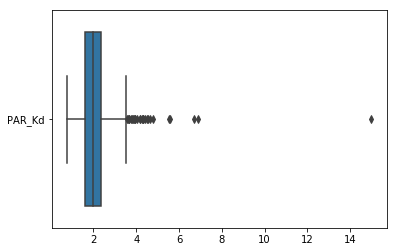

In [3]:
sns.boxplot(data=CS02_Kd, orient='h')

#### The diffusion coefficient (Kd)

If $K_d$ is computed as (Lambert-Beer):  $K_d={1 \over{z2-z1}} \ln({E_d(z_1) \over{E_d(z_2)} })$

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


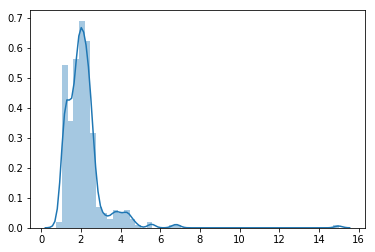

In [4]:
sns.distplot(CS02_Kd.dropna())

### Load the Water Quality, Waves, and Currents data for Station 02 and wrangle:

In [5]:
### Data loads...
## for Water Quality:
CS02_WQ=pd.read_csv(data_path+'CS02/FRF_CS02-EXO_ALL.csv', na_values=-999.990).drop(['gaugeDepth'], axis=1)

## for Surface Waves:
CS02_WV=pd.read_csv(data_path+'CS02/FRF_CS02-SBE26_Waves_ALL.csv', na_values=-999.990).drop(['depth','wavePeakFrequency'], axis=1)

## for Uni-directional Currents:
CS02_WC=pd.read_csv(data_path+'CS02/FRF_CS02-ADOP_Currents_ALL.csv', na_values=-999.990).drop(['aveE','aveN','currentDirection','meanPressure'], axis=1)

### Now for the wrangle part...
## set datetime fields to datatime objects and round to whole second
CS02_WQ['datetime'] = pd.to_datetime(CS02_WQ['datetime'], utc=True).dt.round('1s')
CS02_WV['datetime'] = pd.to_datetime(CS02_WV['datetime'], utc=True).dt.round('1s')
CS02_WC['datetime'] = pd.to_datetime(CS02_WC['datetime'], utc=True).dt.round('1s')


## Assign datetime field to data frame index
CS02_WQ.set_index('datetime', inplace=True)
CS02_WV.set_index('datetime', inplace=True)
CS02_WC.set_index('datetime', inplace=True)

## Aggregate sensor record indices in each of the three dataframes to the full day
CS02_WQ=CS02_WQ.resample('D').mean().copy()
CS02_WV=CS02_WV.resample('D').mean().copy()
CS02_WC=CS02_WC.resample('D').mean().copy()

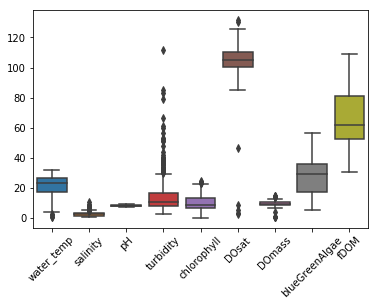

In [6]:
sns.boxplot(data=CS02_WQ)
plt.tick_params(axis='x', rotation=45)

### Station Summary:

In [50]:
CS02_WC.describe()

,currentSpeed
count,645.000000
mean,0.082455
std,0.037960
min,0.020723
25%,0.056351
50%,0.074874
75%,0.101814
max,0.341337


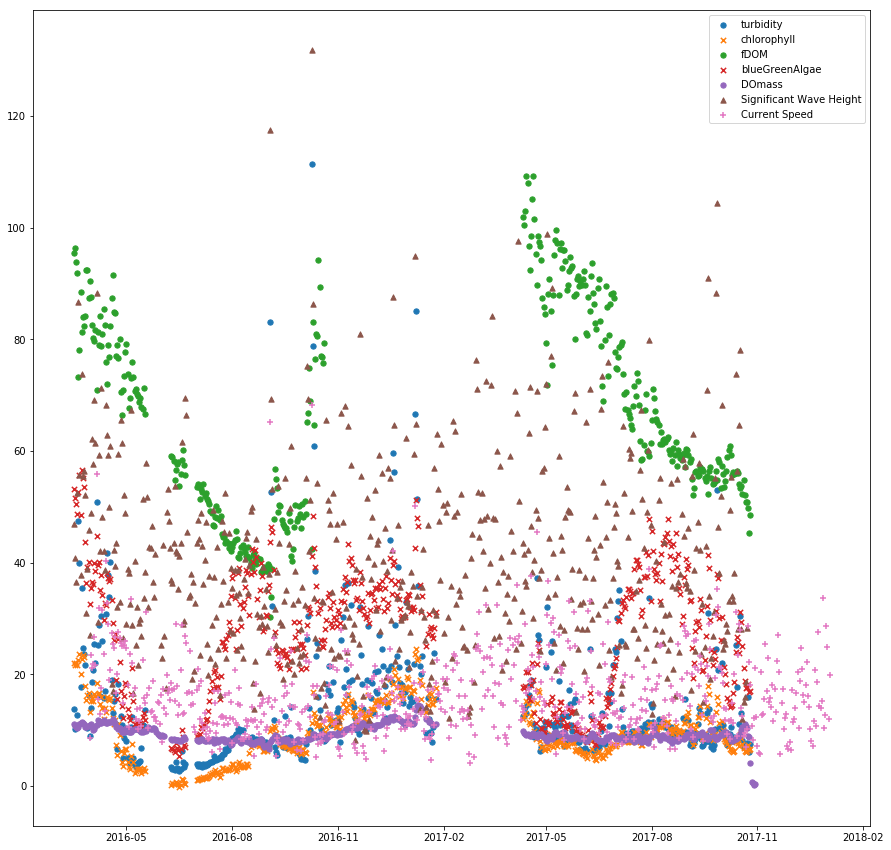

In [48]:
plt.subplots(figsize=(15,15))
    
plt.scatter(CS02_WQ.index, CS02_WQ['turbidity'], s=28, marker='o', label='turbidity')
plt.scatter(CS02_WQ.index, CS02_WQ['chlorophyll'], s=28, marker='x', label='chlorophyll')
plt.scatter(CS02_WQ.index, CS02_WQ['fDOM'], s=28, marker='o', label='fDOM')
plt.scatter(CS02_WQ.index, CS02_WQ['blueGreenAlgae'], s=28, marker='x', label='blueGreenAlgae')
plt.scatter(CS02_WQ.index, CS02_WQ['DOmass'], s=28, marker='o', label='DOmass')
plt.scatter(CS02_WV.index, CS02_WV['waveHs']*200, s=28, marker='^', label='Significant Wave Height')
plt.scatter(CS02_WC.index, CS02_WC['currentSpeed']*200, s=28, marker='+', label='Current Speed')
plt.legend()

### The Relationship between Chl-a and blue-green algae

Bayley et al., 2003 indicate that Chl-a is a suitable proxy for phytoplankton abundance. Let's see what this relationship might look like for Currituck Sound

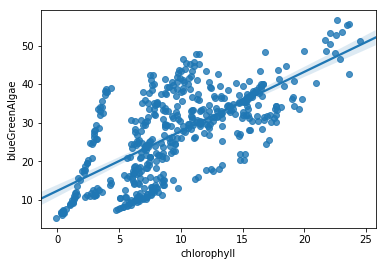

In [8]:
sns.regplot(x='chlorophyll', y='blueGreenAlgae', data=CS02_WQ)

### Salinity at Station 02:

2.4142298971867118

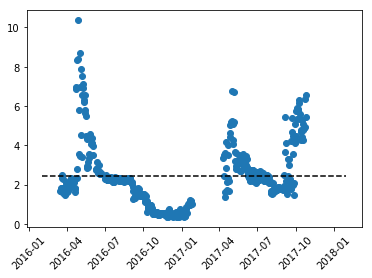

In [52]:
plt.scatter(CS02_WQ.index, CS02_WQ['salinity'])
plt.tick_params(axis='x', rotation=45)
plt.hlines(CS02_WQ['salinity'].mean(), '2016-02-01', '2018-01-31', linestyle='--')
CS02['salinity'].mean()


### Downwelling Diffuse Radiation Attenuation Coefficient - $K_d$ - _Linear_ Correlation Matrix

All station data included (less upper and lower PAR metrics)  

Annotations in matrix are Pearson Product Moment (r) statistics:

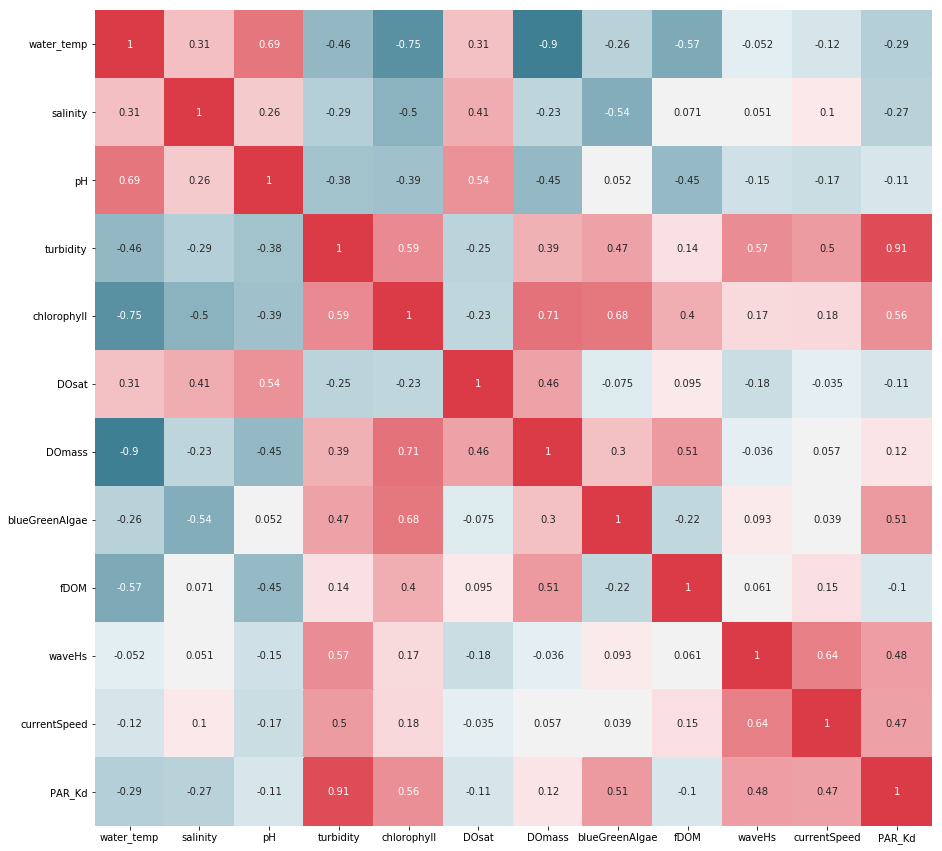

In [9]:
plt.subplots(figsize=(15,15) )
cmap = sns.diverging_palette(220, 10, center='light', as_cmap=True)
sns.heatmap( pd.concat([CS02_WQ, CS02_WV, CS02_WC, CS02_Kd],axis=1).corr(), cbar=False, annot=True, cmap=cmap )

### Downwelling Diffuse Radiation Attenuation Coefficient - $K_d$ - OLS _Exploratory_ Regression Plots

and its relationship to [assumed] controlling factors: surface waves, unidirectional currents, fDOM, Turbidity, and Chl-a 

$K_{d_{total}} = K_{d_{H_2O}} + K_{d_{fDOM}} + K_{d_{Chi-a}} + K_{d_{turbidity}} + K_{d_{surface waves}} + K_{d_{currents}}$

where: <br>
$K_{d_{H_2O}}$ is the optical density of water (not considered here) <br>
$K_{d_{fDOM}}$ is the contribution to $K_{d_{total}}$ from non-algal organic particulates <br>
$K_{d_{Chl-a}}$ is the contribution to $K_{d_{total}}$ from Chlorophyll-a (phytoplankton proxy)<br>
$K_{d_{turbidity}}$ is the contribution to $K_{d_{total}}$ from measured water column turbidity (total suspended inorganic particles)<br>
$K_{d_{surface waves}}$ is the contribution to $K_{d_{total}}$ directly and indirectly attributable to surface waves <br>
$K_{d_{currents}}$ is the contribution to $K_{d_{total}}$ from unidirectional water current(s) <br>

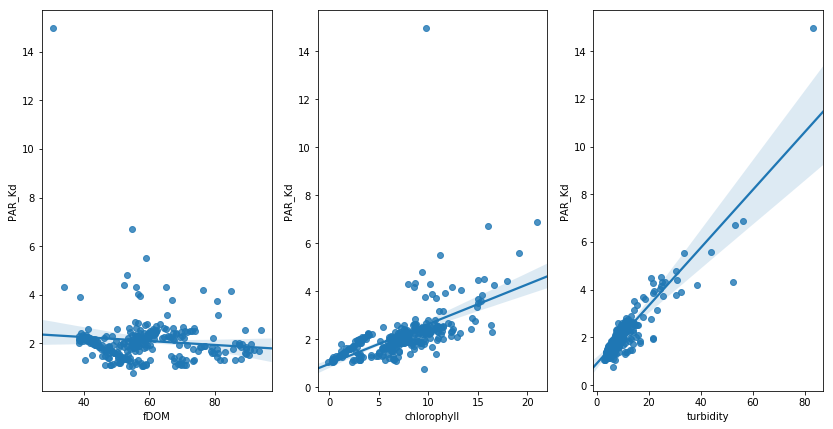

In [11]:
CS02=pd.concat([CS02_WQ, CS02_WV, CS02_WC, CS02_Kd],axis=1)

fig2=plt.figure(figsize=(14,7))
sns.regplot(x='fDOM', y='PAR_Kd', data=CS02, fit_reg=True, order=1, ax=fig2.add_subplot(1,3,1))
sns.regplot(x='chlorophyll', y='PAR_Kd', data=CS02, fit_reg=True, order=1, ax=fig2.add_subplot(1,3,2))
sns.regplot(x='turbidity', y='PAR_Kd', data=CS02, fit_reg=True, order=1, ax=fig2.add_subplot(1,3,3))

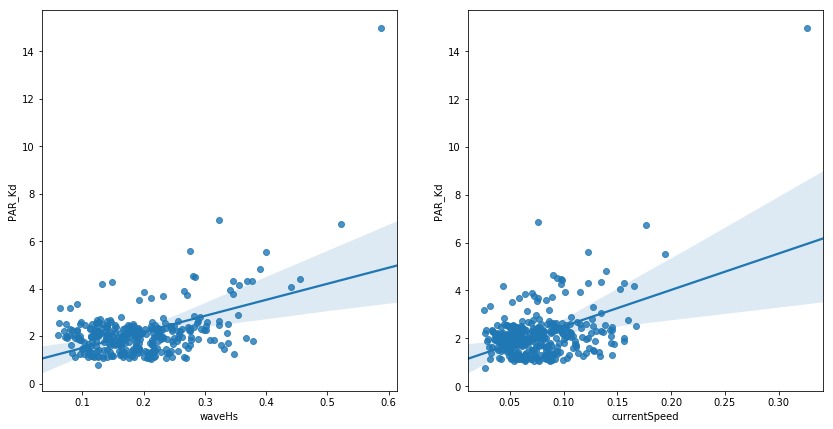

In [12]:
fig3=plt.figure(figsize=(14,7))

sns.regplot(x='waveHs', y='PAR_Kd', data=CS02, ax=fig3.add_subplot(1,2,1))
sns.regplot(x='currentSpeed', y='PAR_Kd', data=CS02, order=1, ax=fig3.add_subplot(1,2,2))

In [38]:
CS02['waveHs'].describe()

count    582.000000
mean       0.202883
std        0.087077
min        0.041550
25%        0.140366
50%        0.189910
75%        0.247551
max        0.659313
Name: waveHs, dtype: float64

#### What if we could somehow remove the high-wind and storm wave effect from the data? 
#### How much might this attempt to isolate "typical" conditions impact results?

The 75th quantile for the significant wave height is 0.247551 m. So, 75% of the waves recorded at Station 02 are < 0.25 m. Though arbitrary, what if we assume (for now) that this 75% condition marks the upper boundary of "typical" wave energy conditions on Currituck Sound?

In [39]:
CS02_=CS02[CS02['waveHs'] < 0.25 ]

,PAR_Kd,fDOM,chlorophyll,turbidity
PAR_Kd,1.000000,0.003322,0.730951,0.770426
fDOM,0.003322,1.000000,0.445378,0.351018
chlorophyll,0.730951,0.445378,1.000000,0.648887
turbidity,0.770426,0.351018,0.648887,1.000000


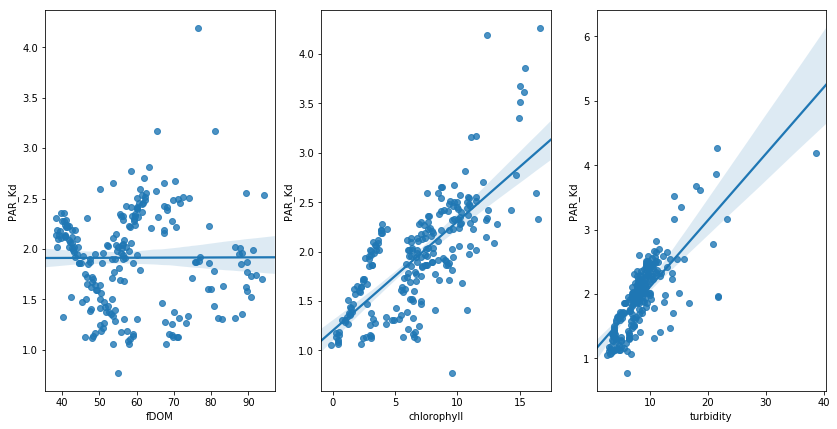

In [40]:
fig4=plt.figure(figsize=(14,7))
sns.regplot(x='fDOM', y='PAR_Kd', data=CS02_, fit_reg=True, order=1, ax=fig4.add_subplot(1,3,1))
sns.regplot(x='chlorophyll', y='PAR_Kd', data=CS02_, fit_reg=True, order=1, ax=fig4.add_subplot(1,3,2))
sns.regplot(x='turbidity', y='PAR_Kd', data=CS02_, fit_reg=True, order=1, ax=fig4.add_subplot(1,3,3))

CS02_[['PAR_Kd', 'fDOM','chlorophyll', 'turbidity']].corr()

,PAR_Kd,waveHs,currentSpeed
PAR_Kd,1.000000,-0.079267,0.028962
waveHs,-0.079267,1.000000,0.447220
currentSpeed,0.028962,0.447220,1.000000


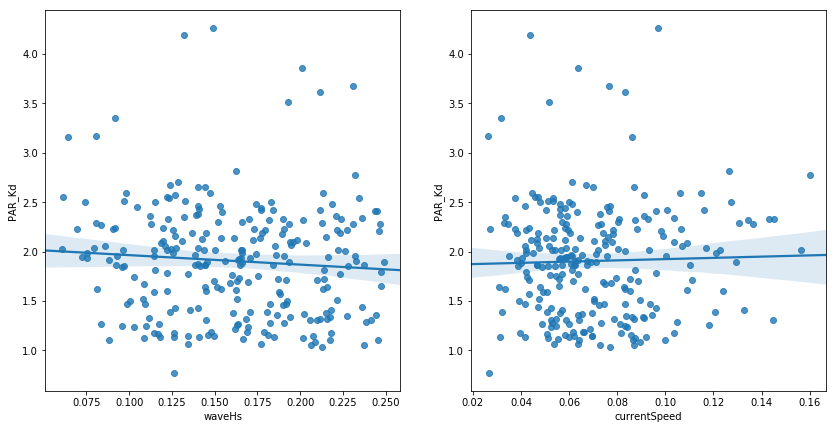

In [42]:
fig5=plt.figure(figsize=(14,7))

sns.regplot(x='waveHs', y='PAR_Kd', data=CS02_, ax=fig5.add_subplot(1,2,1))
sns.regplot(x='currentSpeed', y='PAR_Kd', data=CS02_, order=1, ax=fig5.add_subplot(1,2,2))

CS02_[['PAR_Kd','waveHs','currentSpeed']].corr()

### Multiple Regression Experiment:

In [44]:
#Instantiate the regression model and setting parameters if any,
reg_model = LinearRegression(normalize=True)

R=CS02[['fDOM','chlorophyll','turbidity','waveHs','currentSpeed','PAR_Kd']].dropna()
X=R[['fDOM','chlorophyll','turbidity','waveHs','currentSpeed']]
y=R[['PAR_Kd']]

reg_model.fit(X, y)

P=reg_model.predict(X)

#outputs the coefficients
print('Intercept :', reg_model.intercept_[0], '\n')
print(pd.DataFrame({'features':X.columns,'coeficients':reg_model.coef_[0]}))

print("R^2: {:.2f}".format(reg_model.score(X, y)))

Intercept : 1.2171082358317469 

       features  coeficients
0          fDOM    -0.010378
1   chlorophyll     0.023481
2     turbidity     0.110363
3        waveHs    -0.146136
4  currentSpeed     3.489574
R^2: 0.83


Text(0,0.5,'Observed Kd')

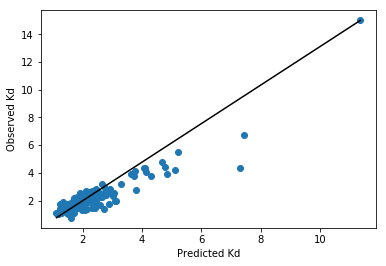

In [45]:
plt.scatter(P,R['PAR_Kd'])
plt.plot([P.min(),P.max()],[R['PAR_Kd'].min(), R['PAR_Kd'].max()], c='black')
plt.xlabel('Predicted Kd')
plt.ylabel('Observed Kd')

In [46]:
import statsmodels.api as sm

model02 = sm.OLS(y, sm.add_constant(X)).fit()
model02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PAR_Kd   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     267.2
Date:                Tue, 07 Aug 2018   Prob (F-statistic):          1.09e-101
Time:                        11:14:10   Log-Likelihood:                -162.07
No. Observations:                 273   AIC:                             336.1
Df Residuals:                     267   BIC:                             357.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.2171      0.145      8.389      0.000       0.931       1.503
fDOM            -0.0104      0.002     -5.223      0.000      -0.014      -0.006
chlorophyll      0.0235      0.009      2.562      0.011       0.005       0.042
turbidity        0.1104      0.005     22.828      0.000       0.101       0.120
waveHs          -0.1461      0.437     -0.334      0.739      -1.007       0.715
currentSpeed     3.4896      0.989      3.528      0.000       1.542       5.437
==============================================================================
Omnibus:                       99.038   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6413.648
Skew:                           0.442   Prob(JB):                         0.00
Kurtosis:                      26.729   Cond. No.                     2.33e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Regressing under "typical" conditions:

In [47]:
R=CS02_[['fDOM','chlorophyll','turbidity','waveHs','currentSpeed',
                                'PAR_Kd']].dropna()
X=R[['fDOM','chlorophyll','turbidity','waveHs','currentSpeed']]
y=R[['PAR_Kd']]

model11 = sm.OLS(y, sm.add_constant(X)).fit()
model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PAR_Kd   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     84.49
Date:                Tue, 07 Aug 2018   Prob (F-statistic):           1.95e-48
Time:                        11:14:52   Log-Likelihood:                -32.698
No. Observations:                 217   AIC:                             77.40
Df Residuals:                     211   BIC:                             97.68
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.4809      0.115     12.861      0.000       1.254       1.708
fDOM            -0.0079      0.001     -5.450      0.000      -0.011      -0.005
chlorophyll      0.0569      0.008      7.561      0.000       0.042       0.072
turbidity        0.0679      0.007     10.412      0.000       0.055       0.081
waveHs          -0.1249      0.469     -0.267      0.790      -1.049       0.799
currentSpeed    -0.4263      0.797     -0.535      0.593      -1.998       1.145
==============================================================================
Omnibus:                       41.431   Durbin-Watson:                   0.739
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.726
Skew:                          -1.001   Prob(JB):                     2.66e-16
Kurtosis:                       4.981   Cond. No.                     2.64e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""